##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gaussian Process Regression in TensorFlow Probability

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this colab, we explore Gaussian process regression using
TensorFlow and TensorFlow Probability. We generate some noisy observations from
some known functions and fit GP models to those data. We then sample from the GP
posterior and plot the sampled function values over grids in their domains.


## Background
Let $\mathcal{X}$ be any set. A *Gaussian process*
(GP) is a collection of random variables indexed by $\mathcal{X}$ such that if
$\{X_1, \ldots, X_n\} \subset \mathcal{X}$ is any finite subset, the marginal density
$p(X_1 = x_1, \ldots, X_n = x_n)$ is multivariate Gaussian. Any Gaussian
distribution is completely specified by its first and second central moments
(mean and covariance), and GP's are no exception. We can specify a GP completely
in terms of its mean function $\mu : \mathcal{X} \to \mathbb{R}$ and covariance function
$k : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$. Most of the expressive power of GP's is encapsulated
in the choice of covariance function. For various reasons, the covariance
function is also referred to as a *kernel function*. It is required only to be
symmetric and positive-definite (see [Ch. 4 of Rasmussen & Williams](
http://www.gaussianprocess.org/gpml/chapters/RW4.pdf)). Below we make use of the
ExponentiatedQuadratic covariance kernel. Its form is

$$
k(x, x') := \sigma^2 \exp \left( \frac{\|x - x'\|^2}{\lambda^2} \right)
$$

where $\sigma^2$ is called the 'amplitude' and $\lambda$ the *length scale*.
The kernel parameters can be selected via a maximum likelihood optimization
procedure.

A full sample from a GP comprises a real-valued function over the entire space
$\mathcal{X}$ and is in practice impractical to realize; often one chooses a set of
points at which to observe a sample and draws function values at these points.
This is achieved by sampling from an appropriate (finite-dimensional)
multi-variate Gaussian.

Note that, according to the above definition, any finite-dimensional
multivariate Gaussian distribution is also a Gaussian process. Usually, when
one refers to a GP, it is implicit that the index set is some $\mathbb{R}^n$
and we will indeed make this assumption here.

A common application of Gaussian processes in machine learning is Gaussian
process regression. The idea is that we wish to estimate an unknown function
given noisy observations $\{y_1, \ldots, y_N\}$ of the function at a finite
number of points $\{x_1, \ldots x_N\}.$ We imagine a generative process

$$
\begin{align}
f \sim \: & \textsf{GaussianProcess}\left(
    \text{mean_fn}=\mu(x),
    \text{covariance_fn}=k(x, x')\right) \\
y_i \sim \: & \textsf{Normal}\left(
    \text{loc}=f(x_i),
    \text{scale}=\sigma\right), i = 1, \ldots, N
\end{align}
$$

As noted above, the sampled function is impossible to compute, since we would
require its value at an infinite number of points. Instead, one considers a
finite sample from a multivariate Gaussian.

$$
  \begin{gather}
    \begin{bmatrix}
      f(x_1) \\
      \vdots \\
      f(x_N)
    \end{bmatrix}
    \sim
    \textsf{MultivariateNormal} \left( \:
      \text{loc}=
      \begin{bmatrix}
        \mu(x_1) \\
        \vdots \\
        \mu(x_N)
      \end{bmatrix} \:,\:
      \text{scale}=
      \begin{bmatrix}
        k(x_1, x_1) & \cdots & k(x_1, x_N) \\
        \vdots & \ddots & \vdots \\
        k(x_N, x_1) & \cdots & k(x_N, x_N) \\
      \end{bmatrix}^{1/2}
    \: \right)
  \end{gather} \\
  y_i \sim \textsf{Normal} \left(
      \text{loc}=f(x_i),
      \text{scale}=\sigma
  \right)
$$

Note the exponent $\frac{1}{2}$ on the covariance matrix: this denotes a
Cholesky decomposition. Comptuing the Cholesky is necessary because the MVN is
a location-scale family distribution. Unfortunately the Cholesky decomposition
is computationally expensive, taking $O(N^3)$ time and $O(N^2)$ space. Much of
the GP literature is focused on dealing with this seemingly innocuous little
exponent.

It is common to take the prior mean function to be constant, often zero. Also,
some notational conventions are convenient. One often writes $\mathbf{f}$ for the
finite vector of sampled function values. A number of interesting notations are
used for the covariance matrix resulting from the application of $k$ to pairs of
inputs. Following [(Quiñonero-Candela, 2005)][QuinoneroCandela2005], we note
that the components of the matrix are covariances of function values at
particular input points. Thus we can denote the covariance matrix as $K_{AB}$
where $A$ and $B$ are some indicators of the collection of function values along
the given matrix dimensions.

[QuinoneroCandela2005]: http://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf

For example, given observed data $(\mathbf{x}, \mathbf{y})$ with implied latent function
values $\mathbf{f}$, we can write

$$
K_{\mathbf{f},\mathbf{f}} = \begin{bmatrix}
  k(x_1, x_1) & \cdots & k(x_1, x_N) \\
  \vdots & \ddots & \vdots \\
  k(x_N, x_1) & \cdots & k(x_N, x_N) \\
\end{bmatrix}
$$

Similarly, we can mix sets of inputs, as in

$$
K_{\mathbf{f},*} = \begin{bmatrix}
  k(x_1, x^*_1) & \cdots & k(x_1, x^*_T) \\
  \vdots & \ddots & \vdots \\
  k(x_N, x^*_1) & \cdots & k(x_N, x^*_T) \\
\end{bmatrix}
$$

where we suppose there are $N$ training inputs, and $T$ test inputs. The above
generative process may then be written compactly as

$$
\begin{align}
\mathbf{f} \sim \: & \textsf{MultivariateNormal} \left(
        \text{loc}=\mathbf{0},
        \text{scale}=K_{\mathbf{f},\mathbf{f}}^{1/2}
    \right) \\
y_i \sim \: & \textsf{Normal} \left(
    \text{loc}=f_i,
    \text{scale}=\sigma \right), i = 1, \ldots, N
\end{align}
$$

The sampling operation in the first line yields a finite set of $N$ function
values from a multivariate Gaussian -- *not an entire function as in the above
GP draw notation*. The second line describes a collection of $N$ draws from
*univariate* Gaussians centered at the various function values, with fixed
observation noise $\sigma^2$.

With the above generative model in place, we can proceed to consider the
posterior inference problem. This yields a posterior distribution over function
values at a new set of test points, conditioned on the observed noisy data from
the process above.

With the above notation in place, we can compactly write the posterior
predictive distribution over future (noisy) observations conditional on
corresponding inputs and training data as follows (for more details, see §2.2 of
[Rasmussen & Williams](http://www.gaussianprocess.org/gpml/)). 

$$
\mathbf{y}^* \mid \mathbf{x}^*, \mathbf{x}, \mathbf{y} \sim \textsf{Normal} \left(
    \text{loc}=\mathbf{\mu}^*,
    \text{scale}=(\Sigma^*)^{1/2}
\right),
$$

where

$$
\mathbf{\mu}^* = K_{*,\mathbf{f}}\left(K_{\mathbf{f},\mathbf{f}} + \sigma^2 I \right)^{-1} \mathbf{y}
$$

and

$$
\Sigma^* = K_{*,*} - K_{*,\mathbf{f}}
    \left(K_{\mathbf{f},\mathbf{f}} + \sigma^2 I \right)^{-1} K_{\mathbf{f},*}
$$

## Imports

In [0]:
import time

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

Populating the interactive namespace from numpy and matplotlib


## Example: Exact GP Regression on Noisy Sinusoidal Data
Here we generate training data from a noisy sinusoid, then sample a bunch of
curves from the posterior of the GP regression model. We use
[Adam](https://arxiv.org/abs/1412.6980) to optimize the kernel hyperparameters
(we minimize the negative log likelihood of the data under the prior). We
plot the training curve, followed by the true function and the posterior
samples.

In [0]:
def sinusoid(x):
  return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
  """Generate noisy sinusoidal observations at a random set of points.

  Returns:
     observation_index_points, observations
  """
  index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
  index_points_ = index_points_.astype(np.float64)
  # y = f(x) + noise
  observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
  return index_points_, observations_

In [0]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

We'll put priors on the kernel hyperparameters, and write the joint distribution of the hyperparameters and observed data using `tfd.JointDistributionNamed`.

In [0]:
def build_gp(amplitude, length_scale, observation_noise_variance):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

We can sanity-check our implementation by verifying that we can sample from the prior, and compute the log-density of a sample.

In [0]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

sampled {'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=9.526471247059396>, 'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=0.7266366332947352>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=1.6714059577238705>, 'observations': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([3.28671007, 3.68127692, 1.46988415, 1.77062709, 1.67811476,
       2.55931267, 1.65328635, 1.73481701, 2.30216517, 1.29280539,
       2.48049681, 2.06504851, 1.24508666, 1.76258146, 1.1567751 ,
       1.12563896, 0.88050047, 2.62427676, 3.35178458, 0.89685013,
       3.22490858, 2.41177716, 2.09414069, 1.77904813, 0.16945602,
       2.53614107, 1.81245418, 1.35642751, 3.68498843, 1.82001509,
       2.03604088, 3.81705144, 3.18142879, 0.57016071, 1.68918439,
       2.85699517, 2.14177352, 3.72928207, 2.17608584, 3.28719282,
       0.6005666 , 1.96646054, 2.13131158, 1.95124967, 0.59090051,
       3.2427046 , 0.83849964, 1.35907388, 2.86403843, 1.56229808,
       

Now let's optimize to find the parameter values with highest posterior probability. We'll define a variable for each parameter, and constrain their values to be positive.

In [0]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]

To condition the model on our observed data, we'll define a `target_log_prob` function, which takes the (still to be inferred) kernel hyperparameters.

In [0]:
# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })

In [0]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 0.875065718641
length_scale: 0.176252877463
observation_noise_variance: 0.0971537576792


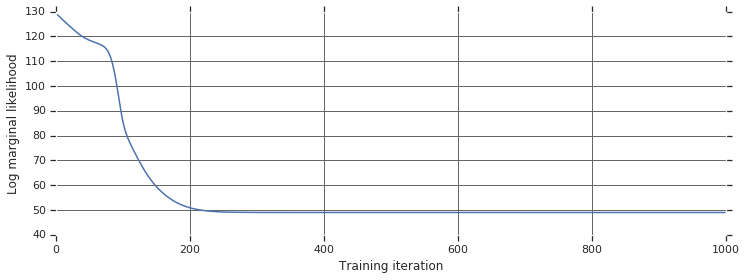

In [0]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [0]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

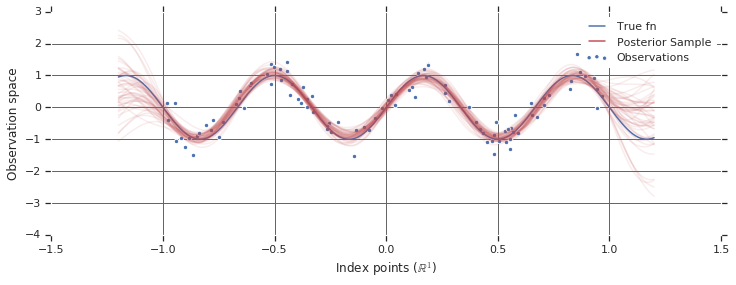

In [0]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

*Note: if you run the above code several times, sometimes it looks great and
other times it looks terrible! The maximum likelihood training of the parameters
is quite sensitive and sometimes converges to poor models. The best approach
is to use MCMC to marginalize the model hyperparameters.*

## Marginalizing hyperparameters with HMC

Instead of optimizing the hyperparameters, let's try integrating them out with Hamiltonian Monte Carlo. We'll first define and run a sampler to approximately draw from the posterior distribution over kernel hyperparameters, given the observations.

In [0]:
num_results = 100
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64),
        num_leapfrog_steps=8),
    bijector=[constrain_positive, constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [tf.cast(x, tf.float64) for x in [1., 1., 1.]]

In [0]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, experimental_compile=False)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 48.94s.


Let's sanity-check the sampler by examining the hyperparameter traces. 

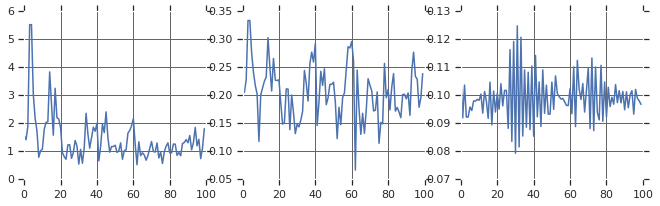

In [0]:
(amplitude_samples,
 length_scale_samples,
 observation_noise_variance_samples) = samples

f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
  ax = f.add_subplot(1, len(samples) + 1, i + 1)
  ax.plot(s)

Now instead of constructing a single GP with the optimized hyperparameters, we construct the *posterior predictive distribution* as a mixture of GPs, each defined by a sample from the posterior distribution over hyperparameters. This approximately integrates over the posterior parameters via Monte Carlo sampling to compute the marginal predictive distribution at unobserved locations.

In [0]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.
batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(
    amplitude_samples, length_scale_samples)

# The batch of kernels creates a batch of GP predictive models, one for each
# posterior sample.
batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_samples,
    predictive_noise_variance=0.)

# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_gprm)

num_samples = 50
samples = predictive_gprm.sample(num_samples)

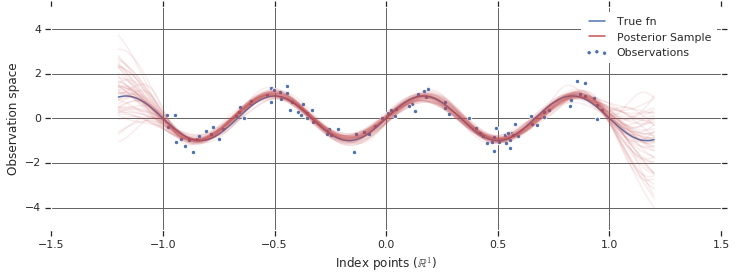

In [0]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

Although the differences are subtle in this case, in general, we would expect the posterior predictive distribution to generalize better (give higher likelihood to held-out data) than just using the most likely parameters as we did above.